# Анализ оттока клиентов банка

**Цель исследования**
Выделение компактных однородных сегментов восокоотточных клиентов на основе анализа значимых признаков отточности с дальнейшей разработкой рекомендаций для оптимизации работы банка по удержанию клиентов.

**Описание данных** \
Анализ проводится на основе датасета с данными о клиентах банка в Ярославле, Рыбинске и Ростове Великом

**План работы**

*Шаг 1 Изучение общей информации*


*Шаг 2 Предобработка данных*
- Замена названий столбцов, преобразование данных в нужные типы 
- Преобразование категориальных переменных в фиктивные в столбцах город и пол  
- Поиск и расчет количества и доли отсутствующих значений 
- Поиск явных и неявных дубликатов 
- Поиск и устранение редких и выбивающихся значений 
- Промежуточный вывод


*Шаг 3 Исследовательский анализ данных*
- Расчет средней доли оттока по банку
- Сравнение портретов типичных клиентов 
- Изучение распределения непрерывных признаков в разрезе оттока 
- Изучение уровней оттока по категориальным признакам 
- Корреляционный анализ


*Шаг 4 Проверка статистических гипотез*
- Проверка гипотезы о различии дохода между ушедшими и оставшимися клиентами 
- Проверка гипотезы о среднем возрасте отточного и лояльного клиента 


*Шаг 5 Промежуточный итог*
- Описание вывявленных взаимосвязей
- Описание признаков, влияющих на отток 


*Шаг 6 Сегментация на основе стратегических показателей*
- Выделение и объединение промежутков оттока по нескольким параметрам в сегменты 
- Приоритезация полученных сегментов по степени отточности


*Шаг 7 Выводы и рекомендации для заказчика*
- Разработка рекомендаций под конкретный сегмент


*Шаг 8 Подготовка презентации*

## Шаг 1 Изучение общей информации

In [1]:
# #Загружаем необходимые библиотеки
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as st
from scipy.stats import mode
import math as mth

import warnings; warnings.filterwarnings(action = 'ignore')

!pip install phik
import phik

In [2]:
# Читаем CSV-файл с данными
df = pd.read_csv('/datasets/bank_data.csv')
df.head()

,USERID,score,city,gender,age,equity,balance,products,credit_card,last_activity,EST_SALARY,churn
0,183012,850.0,Рыбинск,Ж,25.0,1,59214.82,2,0,1,75719.14,1
1,146556,861.0,Рыбинск,Ж,37.0,5,850594.33,3,1,0,86621.77,0
2,120722,892.0,Рыбинск,Ж,30.0,0,NaN,1,1,1,107683.34,0
3,225363,866.0,Ярославль,Ж,51.0,5,1524746.26,2,0,1,174423.53,1
4,157978,730.0,Ярославль,М,34.0,5,174.00,1,1,0,67353.16,1


In [3]:
# Изучаем информацию о таблице
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   USERID         10000 non-null  int64  
 1   score          10000 non-null  float64
 2   city           10000 non-null  object 
 3   gender         10000 non-null  object 
 4   age            9974 non-null   float64
 5   equity         10000 non-null  int64  
 6   balance        7705 non-null   float64
 7   products       10000 non-null  int64  
 8   credit_card    10000 non-null  int64  
 9   last_activity  10000 non-null  int64  
 10  EST_SALARY     10000 non-null  float64
 11  churn          10000 non-null  int64  
dtypes: float64(4), int64(6), object(2)
memory usage: 937.6+ KB


In [4]:
# Выводим общее количество строк и столбцов
df.shape

(10000, 12)

**Промежуточный вывод:** В исследовании используется один датафрейм, содержащий данные о 10000 клиентах банка. Первичное знакомство с данными говорит об их весьма высоком качестве: пропуски присутствуют в 2 столбцах (age, balance) из 12, а корректировка типа данных требуется только в столбце age (float64 -> int64). Также необходимо приведение части столбцов к нижнему регистру (USERID, EST_SALARY) и snake case (USERID). В следующем разделе произведем обозначенные изменения, а также более подробно исследуем данные на предмет возможных дубликатов, изучим пропуски, их природу и возможные варианты дальнейших действий с ними.

## Шаг 2 Предобработка данных

### 2.1 Упорядочивание названий столбцов

In [5]:
# Создаем копию датафрейма для дальнейших манипуляций
data = df.copy()

# Приводим столбцы к нижнему регистру и snake_case
data = data.rename(columns={'USERID': 'user_id', 'EST_SALARY' : 'est_salary'})

# Проверяем
data.columns

Index(['user_id', 'score', 'city', 'gender', 'age', 'equity', 'balance',
       'products', 'credit_card', 'last_activity', 'est_salary', 'churn'],
      dtype='object')

### 2.2 Кодирование переменных

In [6]:
# Преобразуем категориальные переменные в фиктивные для дальнейшего применения в корреляционном анализе

# Cоздадаем копию кодируемого столбца для сохранения оригинального 
data['city_copy'] = data['city']

# Преобразуем копию оригинального столбца
data =pd.get_dummies(data,  columns=['city_copy'])

# Изменяем названия новых столбцов
data = data.rename(columns={'city_copy_Ростов': 'city_rostov', 'city_copy_Рыбинск':'city_rybinsk', 'city_copy_Ярославль':'city_yaroslavl'})

In [7]:
# Кодифицируем категориальный столбец gender
data['gender_bin'] = data['gender'].map({'М': 1, 'Ж': 0})

data.head()

,user_id,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn,city_rostov,city_rybinsk,city_yaroslavl,gender_bin
0,183012,850.0,Рыбинск,Ж,25.0,1,59214.82,2,0,1,75719.14,1,0,1,0,0
1,146556,861.0,Рыбинск,Ж,37.0,5,850594.33,3,1,0,86621.77,0,0,1,0,0
2,120722,892.0,Рыбинск,Ж,30.0,0,NaN,1,1,1,107683.34,0,0,1,0,0
3,225363,866.0,Ярославль,Ж,51.0,5,1524746.26,2,0,1,174423.53,1,0,0,1,0
4,157978,730.0,Ярославль,М,34.0,5,174.00,1,1,0,67353.16,1,0,0,1,1


### 2.3 Обработка пропусков

In [8]:
# Проверяем наличие пропусков явно с помощью метода .isna().sum()
data.isna().sum().sort_values(ascending=False)

balance           2295
age                 26
user_id              0
score                0
city                 0
gender               0
equity               0
products             0
credit_card          0
last_activity        0
est_salary           0
churn                0
city_rostov          0
city_rybinsk         0
city_yaroslavl       0
gender_bin           0
dtype: int64

In [9]:
# Выводим долю пропусков 
round(data.isnull().sum().sort_values(ascending = False) / data.shape[0] *100, 2)

balance           22.95
age                0.26
user_id            0.00
score              0.00
city               0.00
gender             0.00
equity             0.00
products           0.00
credit_card        0.00
last_activity      0.00
est_salary         0.00
churn              0.00
city_rostov        0.00
city_rybinsk       0.00
city_yaroslavl     0.00
gender_bin         0.00
dtype: float64

In [10]:
report = data.isna().sum().to_frame()
report = report.rename(columns = {0: 'missing_values'})
report['% of total'] = (report['missing_values'] / data.shape[0]).round(2)
report.sort_values(by = 'missing_values', ascending = False)

,missing_values,% of total
balance,2295,0.23
age,26,0.00
user_id,0,0.00
score,0,0.00
city,0,0.00
gender,0,0.00
equity,0,0.00
products,0,0.00
credit_card,0,0.00
last_activity,0,0.00


In [11]:
# Создаем копию датафрейма для работы с пропусками
data_nan = data.copy()

# Создаем новые признаки (1 - пропущено значение признака, 0 - не пропущено) для выявления зависимости пропусков от данных
data_nan['age_nan'] = np.where(data_nan['age'].isnull(), 1,0)
data_nan['balance_nan'] = np.where(data_nan['balance'].isnull(), 1,0)

# Удалим нерелевантные столбцы
data_nan = data_nan.drop(columns = ['user_id', 'city', 'gender']) 

data_nan

,score,age,equity,balance,products,credit_card,last_activity,est_salary,churn,city_rostov,city_rybinsk,city_yaroslavl,gender_bin,age_nan,balance_nan
0,850.0,25.0,1,59214.82,2,0,1,75719.14,1,0,1,0,0,0,0
1,861.0,37.0,5,850594.33,3,1,0,86621.77,0,0,1,0,0,0,0
2,892.0,30.0,0,NaN,1,1,1,107683.34,0,0,1,0,0,0,1
3,866.0,51.0,5,1524746.26,2,0,1,174423.53,1,0,0,1,0,0,0
4,730.0,34.0,5,174.00,1,1,0,67353.16,1,0,0,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,814.0,27.0,1,78144.65,1,0,1,18943.64,0,0,1,0,1,0,0
9996,894.0,46.0,0,NaN,1,1,0,196898.29,0,0,0,1,1,0,1
9997,903.0,24.0,0,NaN,2,1,1,108905.09,0,0,0,1,1,0,1
9998,777.0,68.0,3,865457.97,3,0,1,86874.90,0,0,0,1,0,0,0


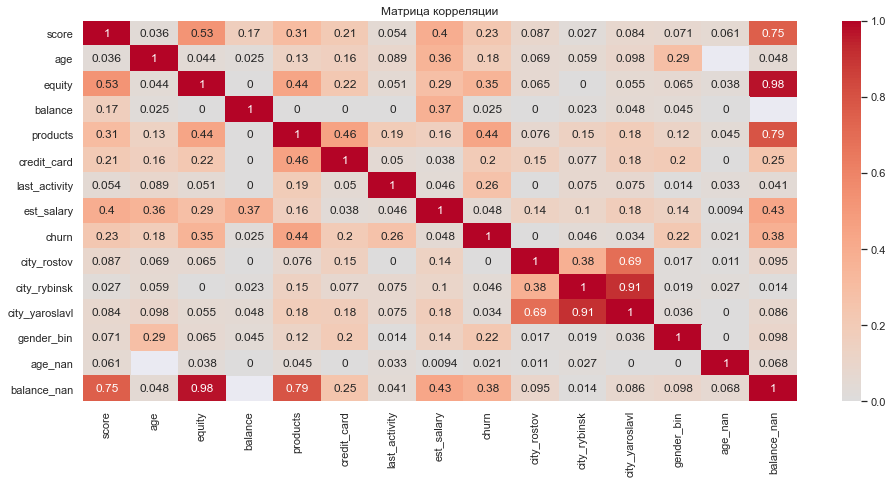

In [12]:
# Построим матрицу корреляции из библиотеки phik для определения наличия зависимости пропусков от переменных 

sns.set(rc={'figure.figsize':(16,7)})

sns.heatmap(data_nan.phik_matrix(interval_cols=['score', 'balance', 'est_salary', 'age']), \
            xticklabels=data_nan.corr().columns, yticklabels=data_nan.corr().columns, cmap='coolwarm', center=0, annot=True)
plt.title("Матрица корреляции")
plt.show()

**Комментарий:** Анализ корреляционной матрицы phik позволил выявить:

- *Столбец age*: корреляция пропусков с остальными данными крайне низкая, значения коэффициента распределены равномерно, что позволяет классифицировать пропуски в данном столбце как MCAR (отсутствующие совершенно случайно). Принимая во внимание, что игнорирование/удаление пропущенных данных не ведет к искажению результатов, и незначительную долю пропусков в данном столбце (26 строк, 0,26% от общего количества), данные строки удаляются из датасета. Вероятнее всего причина пропусков в столбце age - человеческий фактор или технический сбой при внесении данных, поскольку при любом обращении в банк, а тем более оформлении продукта, требуется предоставить паспорт (т е информация о возрасте клиента доступна)


- *Столбец balance:* отмечается наличие взаимосвязи с другими признаками (equity, score, products), разброс значений коэффициента значительный. Кроме того, неизвестно направление этой зависимости. Пропуски классифицируются как MNAR (отсутствующие не случайно). Удалить пропуски не представляется возможным, поскольку приведет к смещению статистических свойств выборки. Аналогичный результат будет получен при заполнении таких пропусков средним арифметическим, медианой или модой. Учитывая значительный объем пропусков (22.95% от общего количества записей / 2295 строк), оставляем записи без изменений. Возможная причина отсутствия данных об остатках на счетах клиента - отсутствие дебетового счета/вклада этого клиента в «Метанпромбанке»

In [13]:
# Удаляем пропуски в столбце age в основном датасете
data = data.query('age.notnull()')

# Проверяем
data.shape

(9974, 16)

In [14]:
# Преобразуем тип данных столбца age в int64 и проверяем
data['age'] = data['age'].astype('int64')

# Проверяем
data['age'].dtype

dtype('int64')

### 2.4 Обработка дубликатов

In [15]:
# Проверяем наличие явных дубликатов
display(data.duplicated().sum())

0

In [16]:
# Проверяем наличие неявных дубликатов по столбцу user_id
display(data[data.duplicated(['user_id'], keep=False)].sort_values(by='user_id'))

# Проверяем наличие дубликатов по ключевым столбцам по сумме параметров
data.duplicated(['user_id', 'city']).sum()

,user_id,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn,city_rostov,city_rybinsk,city_yaroslavl,gender_bin
1893,116540,883.0,Рыбинск,Ж,55,1,362756.49,3,0,1,175920.48,1,0,1,0,0
7694,116540,887.0,Ярославль,Ж,38,0,NaN,1,0,1,119247.61,0,0,0,1,0
4866,117943,855.0,Рыбинск,Ж,32,6,1036832.93,4,1,1,107792.71,1,0,1,0,0
7542,117943,880.0,Ярославль,Ж,40,0,NaN,1,1,0,137718.93,0,0,0,1,0
5863,120258,908.0,Рыбинск,Ж,38,4,2213581.63,2,0,1,160327.77,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2302,220816,934.0,Рыбинск,Ж,74,5,1294285.39,3,1,0,95606.80,0,0,1,0,0
2597,226719,990.0,Ярославль,М,37,4,14648692.14,2,0,0,934412.61,1,0,0,1,1
4216,226719,903.0,Рыбинск,Ж,63,0,NaN,1,1,0,138582.58,0,0,1,0,0
8205,227795,840.0,Рыбинск,М,34,2,350768.03,1,1,0,102036.14,1,0,1,0,1


0

**Комментарий:** Обнаружены совпадающие идентификаторы клиентов, однако остальная ключевая информация разнится, что позволяет предположить задвоение номеров при регистрации новых клиентов в разных городах. Это не позволяет отнести данные записи к неявным дубликатам, соответственно, строки остаются без измененией

### 2.5 Поиск выбивающихся значений

In [17]:
# Изучаем значения числовых столбцов на предмет аномальных значений, выводим характерные значения
display(data[['score', 'age', 'equity', 'balance','products', 'est_salary']].describe().astype(int).round(2))

,score,age,equity,balance,products,est_salary
count,9974,9974,9974,7695,9974,9974
mean,848,42,2,827245,1,147786
std,65,12,1,1980327,0,139285
min,642,18,0,0,0,2546
25%,802,33,0,295698,1,75251
50%,853,40,3,524295,2,119626
75%,900,51,4,980051,2,174499
max,1000,86,9,119113552,5,1395064


**Комментарий:** Не выявлено аномальных занчений в столбцах:

*score* - баллы кредитного скоринга варьируются от 642 до 1000, медианное значение - 853 \
*equity* - приблизительная оценка собственности клиента по балльной системе - располагается в диапазоне от 0 до 9, медиана - 3 \
*age* - среди клиентов банка граждане в возрасте от 18 до 86 лет. Несмотря на то, что клиенты старшего возраста (~70-80+ лет) среди получателей услуг банка могут показаться аномалиями, они тем не менее вполне могут являться полноценными клиентами банка, имея накопительный счет, пенсионный счет или пользоваться другими продуктами банка. Медианный возраст клиента банка - 40 лет 

Выбросы обнаружены в столбцах:

*products* - количество банковских продуктов на клиента не может быть равным 0, поскольку без продуктов это уже не клиент. Записи с нулевыми значениями подлежат удалению \
*balance* - столбец с остатком средств требует дополнительного анализа относительно верхней границы (119'113'552 руб) \
*est_salary* - столбец с оценкой дохода клиента требует дополнительного изучения, поскольку обнаружены зкрайне низкие значения, которые могут быть приняты за аномальные

In [18]:
# Выводим строки с нулевым значением в столбце products
display(data.query('products == 0'))

# Удаляем запись
data = data.query('products != 0')

# Проверяем
len(data.query('products == 0'))

,user_id,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn,city_rostov,city_rybinsk,city_yaroslavl,gender_bin
8957,147837,962.0,Рыбинск,Ж,79,3,NaN,0,0,0,25063.96,1,0,1,0,0


0

In [19]:
# Изучаем более подробно данные в столбце est_salary
# Выводим характерные значения столбца
data['est_salary'].describe().astype(int).round(2)

count       9973
mean      147799
std       139287
min         2546
25%        75252
50%       119643
75%       174499
max      1395064
Name: est_salary, dtype: int32

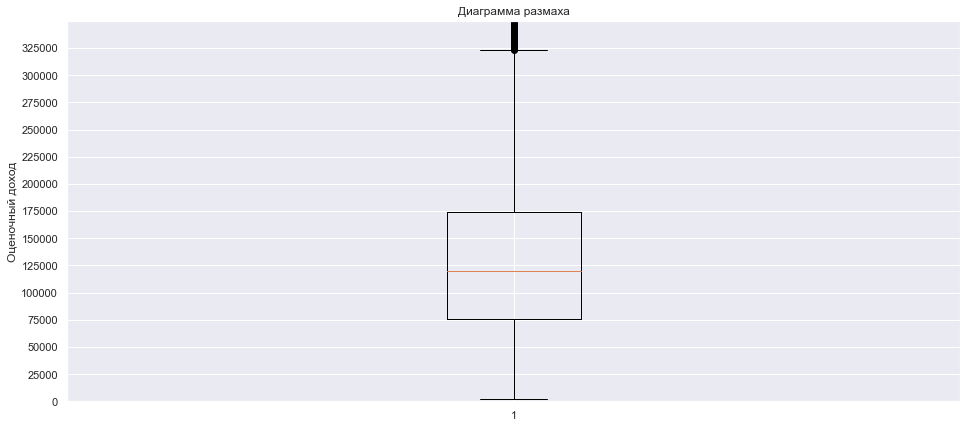

In [20]:
# Строим диаграмму размаха
plt.boxplot(data['est_salary'])
plt.ylim(0, 350000)
plt.yticks(ticks=range(0,350000,25000))
plt.title("Диаграмма размаха") 
plt.ylabel("Оценочный доход")
None

In [21]:
#Узучаем объем данных, выходящих за 1% (т е менее 0.01 и более 0.99 перцентиля)
low_percentele = 0.01
high_percentele = 0.99

est_salary_low = data['est_salary'].quantile(low_percentele)
est_salary_high = data['est_salary'].quantile(high_percentele)

print(f'Нижняя граница est_salary {est_salary_low:.0f}')
print(f'Верхняя граница est_salary  {est_salary_high:.0f}')

print(
    'Процент выбивающихся значений = ',
    round(
        100 - len(data.query('@est_salary_low <= est_salary <= @est_salary_high'))
        / len(data['est_salary']) * 100,
        2
    ),
    '%'
)

Нижняя граница est_salary 17341
Верхняя граница est_salary  886344
Процент выбивающихся значений =  2.01 %


In [22]:
# Удаляем выбивающиеся значения
data = data.query('@est_salary_low <= est_salary <= @est_salary_high')

#Проверяем
display(len(data.query('@est_salary_low >= est_salary >= @est_salary_high')))

# Выводим количество строк после удаления выбросов в столбце est_salary 
data.shape

0

(9773, 16)

**Комментарий:** С помощью анализа характерных значений и диаграммы размаха более детально изучено распределение значений в столбце balance. Медианное значение оценки дохода (119'643) меньше значения среднего арифметического (147'799), при этом значение стандартного отклонения составляет 139287. Можно сделать вывод о наличии аномалий/выбросов. Кроме того, определена значительная разница между минимальным и максимальным значением оценки дохода - 2'546 и 1'395'064 руб. При этом межквартильный размах находится в границах от 75'252 до 174'499. Соответственно, на графике размаха наблюдаем асимметрию данных по немного смещённой медиане (119'643) к нижней грани ящика/первому квартилю и по разной длине усов, выходящих из ящика. Нижний ус ограничен минимальным значением выборки, верхний ~325'000. Распределение не является нормальным

Определены нижняя и верхняя границы значений столбца est_salary, выходящих за 1% (т е менее 0.01 и более 0.99 перцентиля) - 17'341 и 886'344 соответственно. Доля выбивающихся за 1% данных составляет 2.01% и не повлияет на результат исследования при удалении. 

In [23]:
# Изучаем более подробно данные в столбце balance
# Выводим характерные значения столбца
data['balance'].describe().astype(int).round(2)

count         7558
mean        801170
std        1899075
min              0
25%         298299
50%         526761
75%         977610
max      119113552
Name: balance, dtype: int32

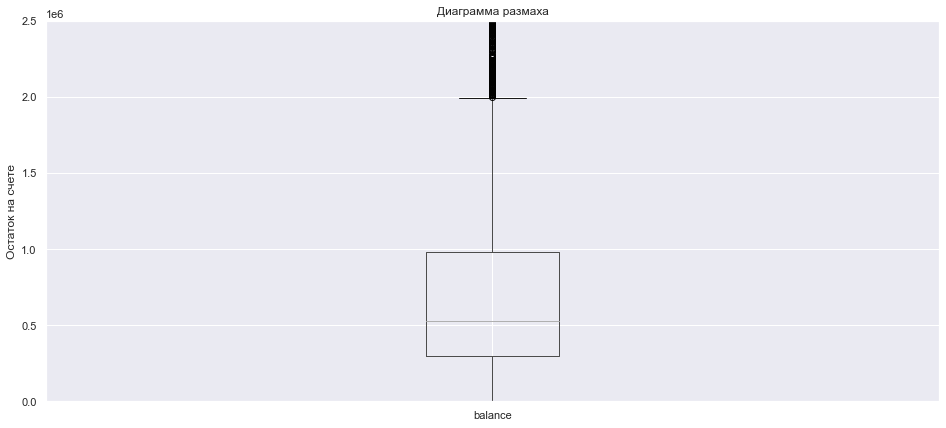

In [24]:
# Строим диаграмму размаха по столбцу balance
data.boxplot(column='balance')
plt.ylim(0, 2500000)
plt.title("Диаграмма размаха") 
plt.ylabel("Остаток на счете")
None

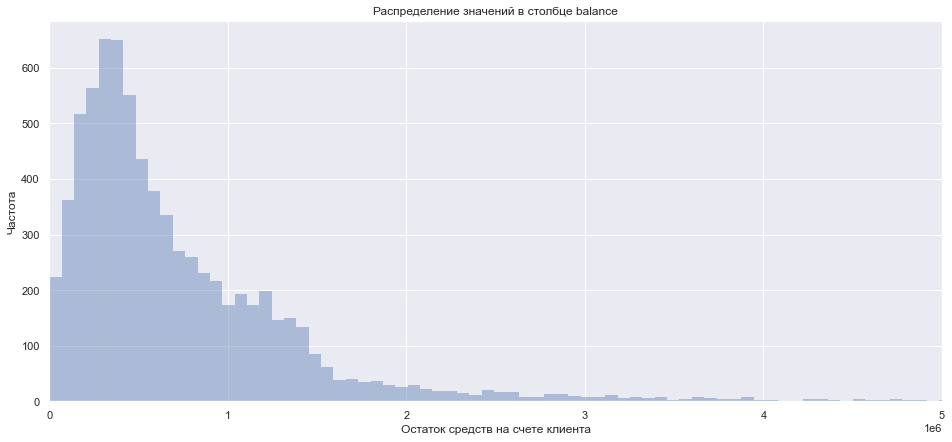

In [25]:
# Смотрим распределение значений в столбце balance 
sns.histplot(data = data['balance'], alpha=0.4)
plt.xlim(0, 5000000)
plt.title('Распределение значений в столбце balance' )
plt.xlabel('Остаток средств на счете клиента')
plt.ylabel("Частота")
None

In [26]:
# Выводим 97 и 99 перцентили в столбце balance
balance_perc = np.percentile(data.loc[data['balance'].notnull()]['balance'], [97, 99]).astype(int)
balance_perc

array([2622542, 4298706])

In [27]:
# Выводим значения, выходящие за пределы 99 перцентиля
data.query('balance >= @balance_perc[1]')

,user_id,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn,city_rostov,city_rybinsk,city_yaroslavl,gender_bin
107,134358,985.0,Рыбинск,Ж,41,4,6749773.07,2,1,0,698013.27,0,0,1,0,0
215,214262,971.0,Ярославль,Ж,35,7,4554977.52,1,1,1,266571.08,1,0,0,1,0
248,180899,930.0,Ярославль,М,32,4,5527695.02,3,0,1,360963.15,0,0,0,1,1
324,221077,925.0,Ярославль,Ж,51,5,5049319.16,3,0,1,224310.01,0,0,0,1,0
517,206059,977.0,Рыбинск,Ж,66,4,6177830.43,1,1,1,278020.40,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9142,223934,969.0,Ярославль,М,39,3,14802129.74,1,1,0,766076.10,0,0,0,1,1
9218,142769,978.0,Рыбинск,М,47,5,4629669.62,4,1,1,207733.36,1,0,1,0,1
9577,189537,959.0,Рыбинск,М,37,5,4804082.21,4,1,0,310739.14,1,0,1,0,1
9753,122015,885.0,Ярославль,М,64,4,25727761.86,3,1,0,168746.90,0,0,0,1,1


In [28]:
# Выводим общее количество и долю значений, выходящих за 1% по верхней границе 
print('Количество выбивающихся значений в столбце balance:', len(data.loc[data['balance'] > balance_perc[1]]))
print('Доля выбивающихся значений в столбце balance: {:.2%}'.format(len(data.loc[data['balance'] > balance_perc[1]]) /data.shape[0]))

Количество выбивающихся значений в столбце balance: 76
Доля выбивающихся значений в столбце balance: 0.78%


**Комментарий:** Распределение в столбце balance во многом схоже с распределением значений в est_salary: отмечается значимая разница между средним арифметическим и медианным значениями (801'170 и 526'761 руб соответственно), стандартное отклонение (1'899'075 руб) более чем в 2 раза превосходит среднее арифметическое, диапазон значений максимально широкий (от 0 до 119'113'552 руб). Все это свидетельствует о наличии выбросов, что хорошо видно на гистограмме (отмечаем "скошенный" вправо график, единичные значения после отметки в 4'000'000 руб) и диаграмме размаха (асимметрия данных по смещённой медиане к нижней грани ящика и по разной длине усов. Нижний ус ограничен минимальным значением выборки (0), верхний 119'113'552). Распределение не является нормальным.

Несмотря на то, что лишь 1% клиентов имеет остаток на счете, превышающий 4'298'706 руб (76 строк, 0.78% от общего количества записей), эти значения не могут быть признаны выбросами и быть удалены, поскольку клиенты с ультравысокими доходами также являются значимым сегментом клиентов и должны обязательно учитываться в выборке во избежание искажения результатов исследования

In [29]:
# Выводим общее количество и долю удаленных данных
print('Общее количество удаленных строк:', df.shape[0]-data.shape[0])
print('Доля удаленных строк:{:.2%}'.format((df.shape[0]-data.shape[0])/df.shape[0]))

Общее количество удаленных строк: 227
Доля удаленных строк:2.27%


**Промежуточный вывод:** В ходе этапа предобработки были проведены следующие действия:

- Общее количество строк сократилось на 2.27% (227 записей), в том числе за счет удаления пропусков и аномальных значений.


- Пропуски обнаружены в столбцах age (0.26%) и balance (22.95%). С помощью корреляционного анализа (матрица phik) пропуски в столбце age классифицированы как «совершенно случайные» (MCAR), что позволило удалить их без искажения  распределения статистических свойств выборки. Возможная причина возникновения – человеческий фактор или технический сбой. Пропуски в столбце balance классифицированы как  «неслучайные» (MCAR) из-за наличия взаимосвязи с другими признаками (equity, score, products) и значительного разброса значений коэффициента корреляции. Из-за невозможности удалить или заполнить пропуски записи оставлены без изменений. Возможная причина возникновения пропусков - отсутствие дебетового счета/вклада клиента в банке-заказчике и, как следствие, данных об остатках денежных средств на счетах


- Аномальными значениями в столбце est_salary признаны данные, выходящие за 1% (т е менее 1 и более 99 перцентили), их доля составила 2.01%. Кроме того, была удалена 1 запись в столбце products


- Явные и неявные дубликаты не обнаружены. Найденные совпадения по идентификатору клиента не удалось подтвердить в качестве дубликатов ввиду разницы других параметров или отсутствия дополнительных признаков, позволяющих классифицировать данные как дублирующие.  Вероятно имеет место задвоение номеров при регистрации новых клиентов в разных городах


- Категориальные переменные в столбцах city и gender преобразованы в фиктивные для дальнейшего применения в исследовательском анализе

## Шаг 3 Исследовательский анализ данных

### 3.1 Портрет отточного и лояльного клиента

In [30]:
# Выводим меры центральной тендецнии для непрерывных и дискретных величин в разбивке по отточным и неотточным клиентам
data_cont_disc = data.pivot_table(index='churn', \
                                  aggfunc= {'score':'mean', 'age':'median','equity':'median', \
                                            'balance':'mean', 'products':'median', 'est_salary':'mean'}).astype(int)
data_cont_disc

,age,balance,equity,est_salary,products,score
churn,,,,,,
0,40,713129,3,139389,2,845
1,39,1085909,4,142197,2,862


In [31]:
# Выводим меры центральной тендецнии для категориальных данных
data_cat=data.pivot_table(index = 'churn', values = ['city', 'gender', 'last_activity', 'credit_card'], aggfunc = lambda x: x.mode())
data_cat

,city,credit_card,gender,last_activity
churn,,,,
0,Ярославль,1,Ж,0
1,Ярославль,1,М,1


In [32]:
# Объединяем таблицы и транспонируем
data_cont_disc.merge(data_cat, on='churn').T

churn,0,1
age,40,39
balance,713129,1085909
equity,3,4
est_salary,139389,142197
products,2,2
score,845,862
city,Ярославль,Ярославль
credit_card,1,1
gender,Ж,М
last_activity,0,1


**Комментарий:** Меры центральной тенденции позволили составить портреты типичных отточных и неотточных клиентов. Данные во многом схожи, однако есть и различия

*Профиль типичного лояльного клиента* - женщина 40 лет из Ярославля с доходом 140'000 руб и остатком собственных средств около 713'000, имеющая 2 банковских продукта, в т ч кредитную карту. Собственность типичного лояльного клиента оценивается в 3 балла (по шкале до 9), кредитный скоринг равен 845 баллам из 1000. За поледние несколько месяцев у клиента не было отмечено активности, связанной с возможным уходом.


*Профиль типичного отточного клиента* - мужчина 39 лет из Ярославля с доходом около 142'000 руб и остатком собственных средств в размере 1'085'000 руб, в среднем имеющий 2 банковских продукта, включая кредитную карту. Собственность типичного нелояльного клиента оценивается в 4 балла (по шкале до 9), кредитный скоринг равен 862 баллам из 1000. Клиент совершал действия, свидетельствующие о планируемом отказе от услуг банка, в течение последних нескольких месяцев. 

Портреты типичных лояльных и нелояльных клиентов схожи: люди среднего возраста 39-40 лет из Ярославля с ежемесячным совокупным доходом около 140'000 руб, с хорошим баллом собственности 3-4, пользующиеся 2 пакетами услуг банка, включая кредитную карту, и в целом являющиеся благонадежными клиентами со средним скоринговым баллом 845 (неотточные) и 862 (отточные). Основные различия состоят в размере остатков собственных средств на счете (у отточных клиентов он почти в полтора раза выше, чем у лояльных - 1'085'000 руб против 713'000 руб), половой принадлежности (мужчины прекращают обслуживание в банке чаще женщин) и совершении действий, потенциально связанных с возможным уходом из банка (отточные клиенты мх совершают, неотточные - нет)   

При расчете мер центральной тендецнии для непрерывных величин использовалось среднее арифметическое, дискретных - медиана, категориальных - мода

### 3.2 Распределение непрерывных величин в разрезе оттока 

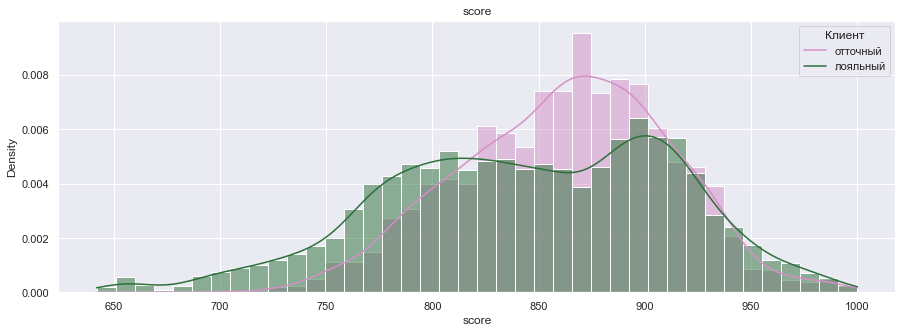

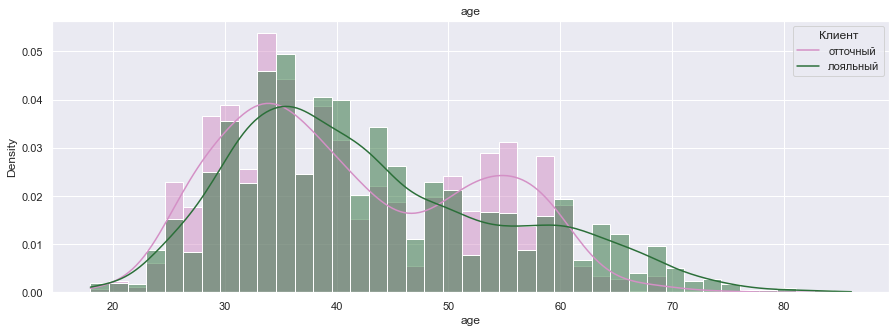

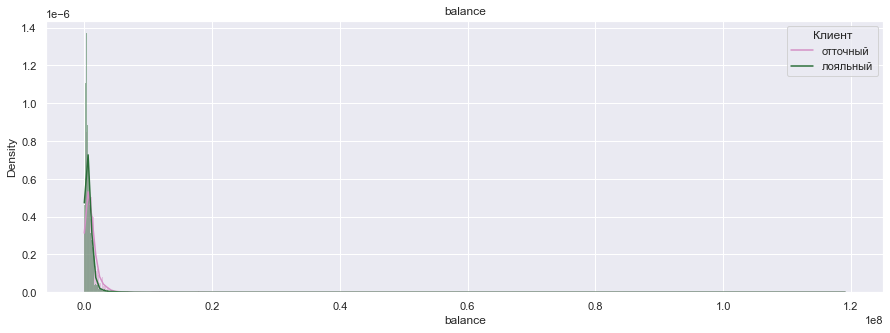

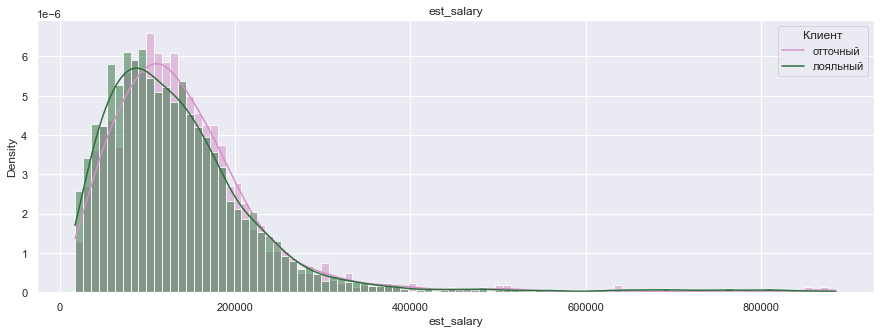

In [33]:
# Строим графики распределений (нормализованные гистограммы) для выявления промежутков оттока клиентов 
for column in ['score', 'age', 'balance', 'est_salary']:
    plt.figure(figsize=(15, 5))
    ax = sns.histplot(
        data = data[['churn', column]],
        x= column,
        stat='density',
        common_norm=False,
        hue='churn',
        kde=True,
        palette='cubehelix')
    plt.title(column)
    ax.legend(["отточный", "лояльный"], title='Клиент')
    
    plt.show()


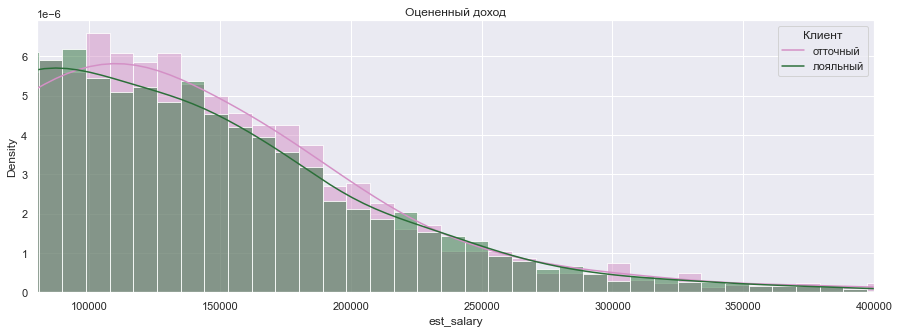

In [34]:
# Изменим масштаб для более точного определения промежутков отточности в столбце est_salary
plt.figure(figsize=(15, 5))
ax = sns.histplot(
     data = data[['churn', 'est_salary']],
     x= 'est_salary',
     stat='density',
     common_norm=False,
     hue='churn',
     kde=True,
     palette='cubehelix')
plt.title('Оцененный доход')
ax.legend(["отточный", "лояльный"], title='Клиент')
plt.xlim(80000, 400000)
None

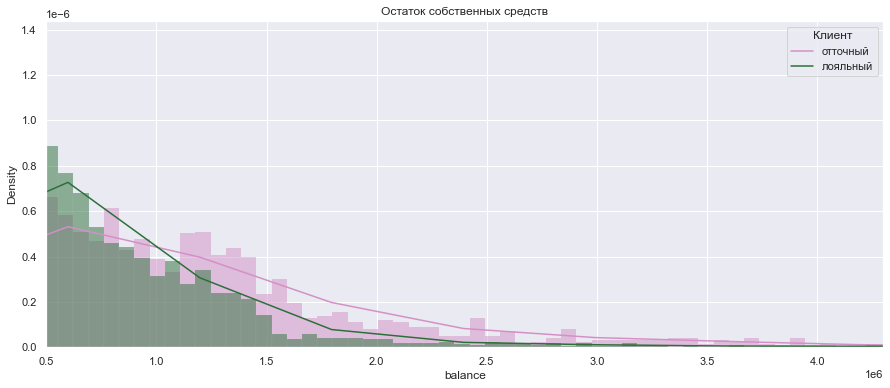

In [35]:
# Выводим график по столбцу balance в более удобном масштабе (без "хвоста" до максимального значения) 
plt.figure(figsize=(15, 6))
ax = sns.histplot(
     data = data[['churn', 'balance']],
     x= 'balance',
     stat='density',
     common_norm=False,
     hue='churn',
     kde=True,
     palette='cubehelix')
plt.title('Остаток собственных средств')
ax.legend(["отточный", "лояльный"], title='Клиент')
plt.xlim(500000, 4300000)
None


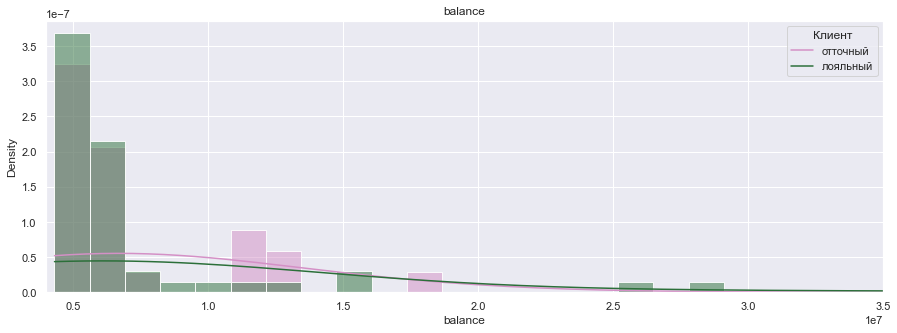

In [36]:
# Выводим "хвост" графика по столбцу balance для поиска промежутков отточности в подходящем масштабе
plt.figure(figsize=(15, 5))
ax= sns.histplot(
     data = data.query('balance.quantile(0.99)<=balance'),
     x= 'balance',
     stat='density',
     common_norm=False,
     hue='churn',
     kde=True,
     palette='cubehelix')
plt.title('balance')
ax.legend(["отточный", "лояльный"], title='Клиент')
plt.xlim(4000000, 35000000)
None

**Комментарий:** Нормализованные гистограммы позволили определить следующие промежутки отточности:

- Кредитный скоринг в диапазоне от 825 до 911 и от 919 до 937 баллов
- Возраст 25-34 и 49-59 лет
- Остаток собственных средств (руб) 760'000-810'000, 900'000-1'050'000, 1'100'000 - 4'600'000, 6'000'000 - 7'000'000, 8'000'000 - 9'000'000, 11'000'000 - 13'000'000, 64'000'000 - 65'000'000
- Ежемесячный доход (руб) в диапазонах 99'000 - 135'000 , 143'000 - 215'000, 225'000 - 235'000, 254'000 - 265'000, 297'000 - 305'000, 325'000 - 335'000, 398'000 - 407'000, 498'000 - 515'000, 634'000 - 642'000, 850'000 - 859'000, 868'000 - 876'000

### 3.3 Уровень оттока по категориям

In [37]:
# Рассчитываем среднюю долю оттока по банку
print(f'Средняя доля оттока по банку: {len(data.query("churn == 1")) / len(data["churn"]):.2%}')

Средняя доля оттока по банку: 18.38%


In [38]:
# Создаем функцию для вывода свобной таблицы по каждому категориальному и бинарному признаку
'''
    Функция принимает на вход название столбца, по которому делается группировка 
    с последующей аггрегацией информации об оттоке
    Функция выводит сводную таблицу, в которой для каждой категории рассчитано общее количество клиентов и доля оттока
    как среднее значение по столбцу churn 
    '''    
def pivot_by_cat(column):
    pivot_cat = data.pivot_table(index=[column], aggfunc={column:'count','churn':'mean'})\
                    .sort_values(by='churn', ascending=False)
                    
    return pivot_cat

In [39]:
# Создаем функцию для вывода столбчатой диаграммы по каждому категориальному и бинарному признаку
'''
    Функция принимает на вход название столбца
    Функция строит столбчатую диаграмму с долей оттока в каждой категории с дополнительной осью со средним оттоком по банку
    ''' 
    
def plt_by_cat(column):
    plt.figure(figsize=(12, 5))
    ax = sns.barplot(x=column, y='churn', data=data, palette='vlag')
    ax.axhline(0.18, color='r', linestyle ='--', label='средний отток по банку')
    plt.legend()
 
    return ax

,churn,city
city,,
Ярославль,0.191812,5740
Ростов,0.188584,1384
Рыбинск,0.163835,2649


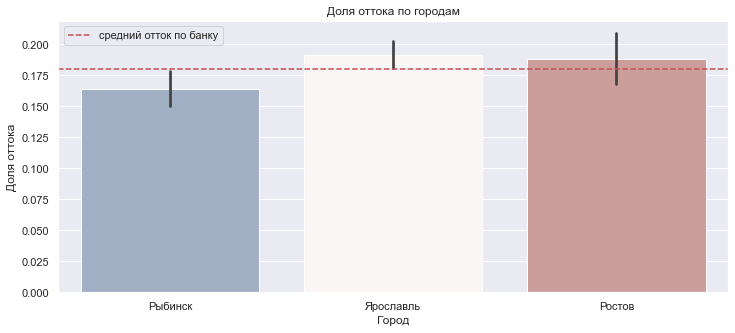

In [40]:
# Выводим сводную таблицу по с долей оттока по городам
display(pivot_by_cat('city'))

# Выводим столбчатую диаграмму с долей оттока по городам и средней по банку
plt_by_cat('city')

plt.title('Доля оттока по городам')
plt.xlabel('Город')
plt.ylabel('Доля оттока')
None

,churn,gender
gender,,
М,0.238212,4899
Ж,0.129052,4874


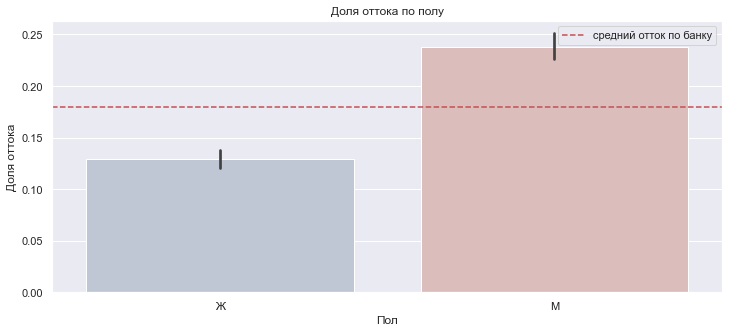

In [41]:
# Выводим сводную таблицу с долей оттока по полу
display(pivot_by_cat('gender'))

# Выводим столбчатую диаграмму с долей оттока по полу и средней по банку
plt_by_cat('gender')

plt.title('Доля оттока по полу')
plt.xlabel('Пол')
plt.ylabel('Доля оттока')
None

,churn,equity
equity,,
9,0.538462,13
7,0.467532,77
6,0.374194,155
8,0.352941,17
5,0.301756,1879
4,0.254265,1817
3,0.207261,1515
2,0.160194,1030
1,0.122047,762


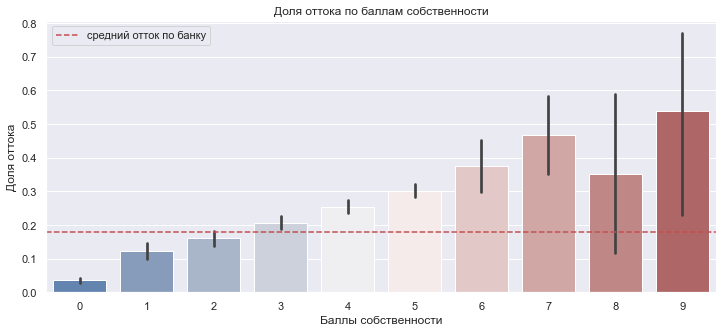

In [42]:
# Выводим сводную таблицу с долей оттока по баллам собственности
display(pivot_by_cat('equity'))

# Выводим столбчатую диаграмму с долей оттока по баллам собственности и средней по банку
plt_by_cat('equity')

plt.title('Доля оттока по баллам собственности')
plt.xlabel('Баллы собственности')
plt.ylabel('Доля оттока')
None

,churn,products
products,,
4,0.636559,465
5,0.421053,19
3,0.290640,1015
2,0.192668,5019
1,0.070661,3255


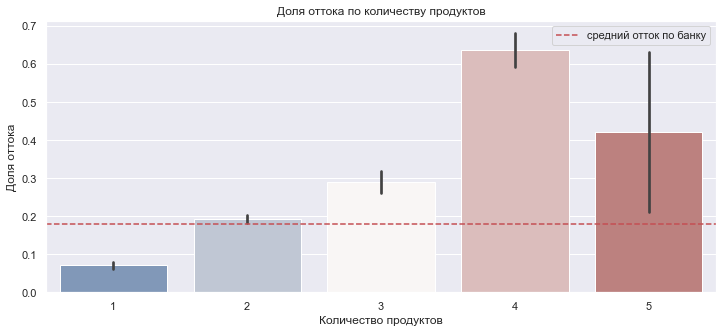

In [43]:
# Выводим сводную таблицу с долей оттока по количеству продуктов
display(pivot_by_cat('products'))

# Выводим столбчатую диаграмму с долей оттока по количеству продуктов и средней по банку
plt_by_cat('products')

plt.title('Доля оттока по количеству продуктов')
plt.xlabel('Количество продуктов')
plt.ylabel('Доля оттока')
None

,churn,last_activity
last_activity,,
1,0.246479,5112
0,0.114997,4661


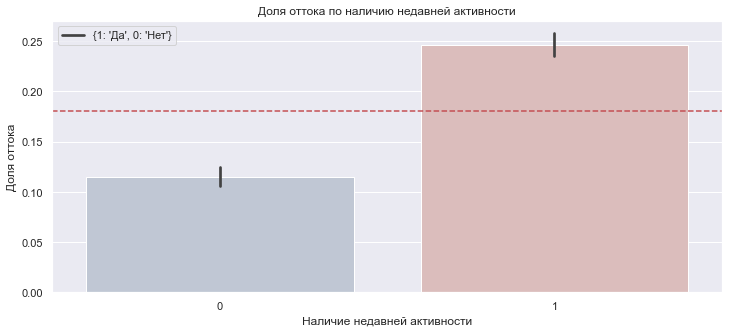

In [44]:
# Выводим сводную таблицу с долей оттока по наличию недавней активности
display(pivot_by_cat('last_activity'))

# Выводим столбчатую диаграмму с долей оттока по наличию недавней активности и средней по банку
plt_by_cat('last_activity')

plt.title('Доля оттока по наличию недавней активности')
plt.xlabel('Наличие недавней активности')
plt.ylabel('Доля оттока')
plt.legend(labels=[{1:'Да', 0:'Нет'}])
None

,churn,credit_card
credit_card,,
0,0.257880,3141
1,0.148673,6632


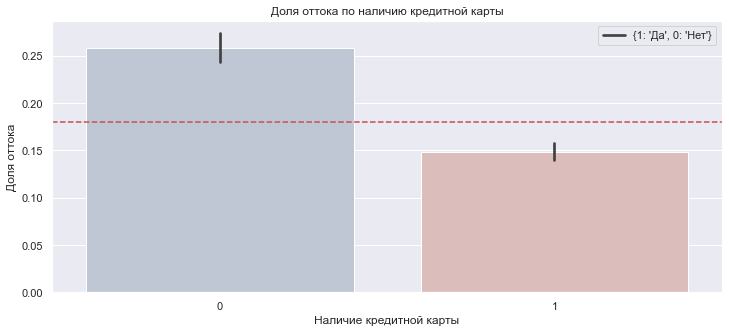

In [45]:
# Выводим сводную таблицу с долей оттока по наличию кредитной карты
display(pivot_by_cat('credit_card'))

# Выводим столбчатую диаграмму с долей оттока по наличию кредитной карты и средней по банку
plt_by_cat('credit_card')

plt.title('Доля оттока по наличию кредитной карты')
plt.xlabel('Наличие кредитной карты')
plt.ylabel('Доля оттока')
plt.legend(labels=[{1:'Да', 0:'Нет'}])
None

**Комментарий:** В ходе исследования были установлены наиболее высокоотчные клиенты внутри ряда признаков, в том числе:

- Отточность, превышающая среднебанковскую (18.38%), отмечена в Ярославле (19.18%) и Ростове (18.85%), при этом в Ярославле клиентская база в 4 раза больше, чем в Ростове: 5740 и 1384 соответственно. В Рыбинске ситуация немного лучше, однако доля отточных клиентов также значительна 16.38% от общего количества 2649 клиентов.


- Клиентская база банка поровну распределена между мужчинами и женщинами (4899 и 4874 соответственно). Однако мужчины значительно чаще принимают решение прекратить обслуживание в банке: доля оттока клиентов мужского пола выше средней по банку и составляет 23.82%. Доля ушедших клиентов среди женщин в 2 раза ниже (12.90%)


- Наибольшая доля оттока наблюдается в самых малочисленных группах клиентов (вероятно ВИП) с баллом собственности от 6 до 9. В этой прослойке клиентов доля оттока варьируется от 35 до 54%, что в несколько раз превышает среднюю по банку. Также весьма отточным представляется пласт клиентов с рейтингом собственности от 3 до 5, где отточность колеблется от 21 до 30%. Важно отметить, что именно эта группа составляет 50% от всей клиентской базы банка. Клиенты банка с низким уровнем собственности (0-2) являются самой лояльной аудиторией, особенно самая большая ее часть (2508 клиентов) с уровнем отточности 4%


- Только клиенты с 1 пакетом продуктов не являются отточными (7% оттока), они составляются треть всех клиентов банка. Половина клиентов банка (5019) пользуется 2-мя пакетами продуктов и балансирует на грани отточности с 19%. На оставшуюся группу ~1500 клиентов приходятся наиболее выкоотточные клиенты: 3 пакета услуг - 29%, 5 пакетов - 42% и самая нелояльная категория -64% оттока среди клиентов с 4-мя пакетами


- Из 5112 клиентов, совершавших в течение нескольких месяцев действия, потенциально связанные с их уходом из базы, 25% действительно приняли такое решение. Среди тех, кто такие действия не совершал, отточность лишь 11%


- Отток среди клиентов, не пользующихся кредитными картами банка, превышает средний по банку на 8%, достигая 26%. 2/3 клиентов банка имеют кредитные карты, доля нелояльных клиентов среди них невысока - 15%  

### 3.4 Корреляционный анализ

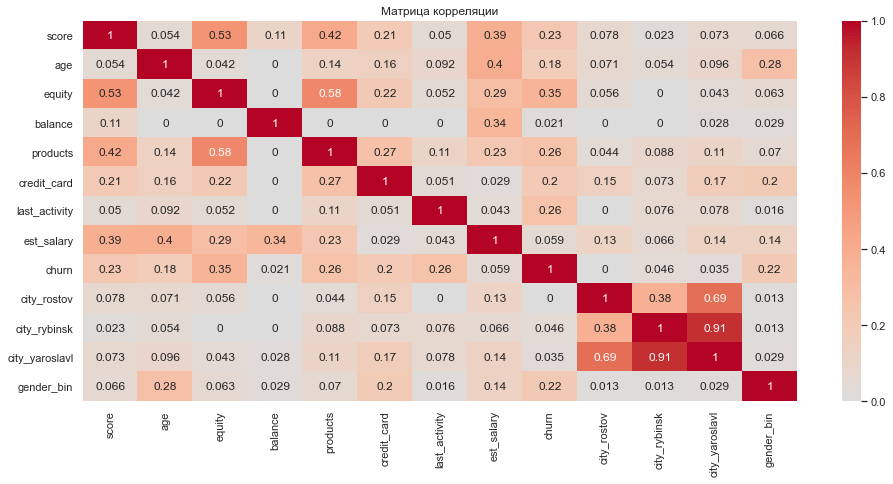

In [46]:
# Cтроим матрицу корреляции из библиотеки phik для определения наличия зависимости отточности от различных признаков 

# Удалим нерелевантные столбцы
data_corr = data.drop(columns = ['user_id', 'city', 'gender']) 

sns.heatmap(data_corr.phik_matrix(interval_cols=['score', 'balance', 'est_salary', 'age']), \
            xticklabels=data_corr.corr().columns, yticklabels=data_corr.corr().columns, cmap='coolwarm', center=0, annot=True)
plt.title("Матрица корреляции")
plt.show()

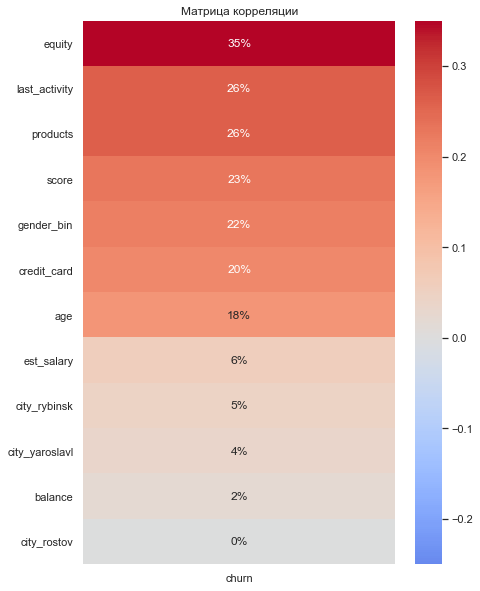

In [47]:
# Выводим отдельно столбец churn
plt.figure(figsize=(7, 10))
sns.heatmap(data_corr.phik_matrix(interval_cols=['score', 'balance', 'est_salary', 'age'])[['churn']]\
            .sort_values(by='churn', ascending=False).drop(['churn'], axis=0), 
            vmin=-0.25, vmax=0.35, annot=True, annot_kws={"size":12}, fmt='.0%', cmap='coolwarm', center=0)
plt.title("Матрица корреляции")
plt.show()

**Комментарий:** С помощью матрицы корреляции phik удалось установить:

- Наличие сильной взаимосвязи оттока клиентов от количества баллов собственности (коэффициент корреляции 0.35) и в равной степени от количества пакетов услуг и недавней активности (по 0.26) 


- Отточность также зависит от скоринговых баллов (0.23), пола (0.22), наличия кредитной карты (0.2) и возраста (0.18)


- Практически нет корреляции между отточностью клиентов и ежемесячным доходом (0.06), городами (Рыбинск 0.05, Ярославль 0.04, Ростов 0) и остатком средств на счете (0.02) 

Стоит отметить, что в то время как библиотека phik обнаруживает нелинейные зависимости, она не показывает направление зависимости, а лишь ее наличие.

## Шаг 4 Проверка статистических гипотез

### 4.1 Проверка гипотезы о различии дохода между ушедшими и оставшимися клиентами

#### 4.1.1 Проверка выборок на нормальность распределения 

In [48]:
# Формируем выборки 

# Выборка доходов лояльных клиентов
est_sal_0=data.loc[data['churn'] == 0]['est_salary']
print('Размер выборки доходов лояльных клиентов: ', len(est_sal_0), 'наблюдений')

# Выборка доходов отточных клиентов
est_sal_1=data.loc[data['churn'] == 1]['est_salary']
print('Размер выборки доходов отточных клиентов: ', len(est_sal_1), 'наблюдений')


Размер выборки доходов лояльных клиентов:  7977 наблюдений
Размер выборки доходов отточных клиентов:  1796 наблюдений


In [49]:
# Поверяем данные выбороки доходов лояльных клиентов на нормальность распределения
# Выводим статистические характеристики выборки лояльных клиентов
est_sal_0.describe().astype('int')

count      7977
mean     139389
std      106765
min       17349
25%       74529
50%      118249
75%      172487
max      885750
Name: est_salary, dtype: int32

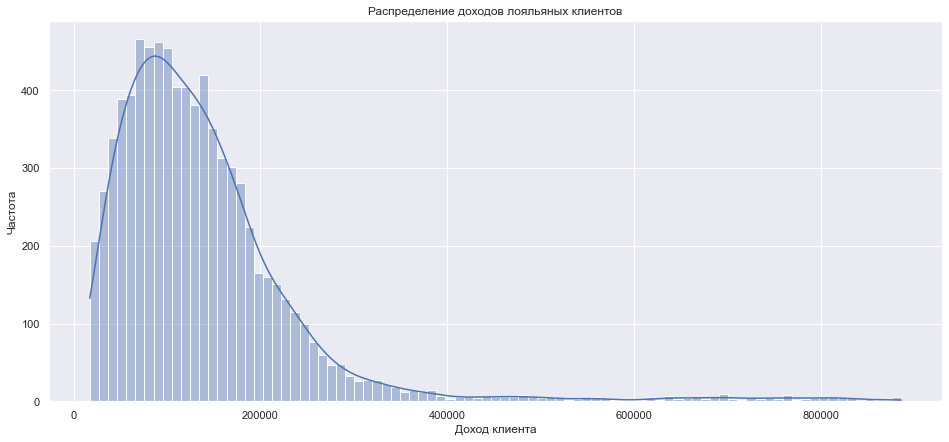

In [50]:
# Cтроим гистограмму
sns.histplot(data = est_sal_0, alpha=0.4, kde=True)
plt.title('Распределение доходов лояльяных клиентов' )
plt.xlabel('Доход клиента')
plt.ylabel("Частота")
None

In [51]:
alpha = 0.05  # критический уровень статистической значимости

results = st.shapiro(est_sal_0)
p_value = results[1]

print('p-значение: ', p_value)

if p_value < alpha:
    print('Отвергаем нулевую гипотезу: распределение не нормально')
else:
    print('Не получилось отвергнуть нулевую гипотезу, всё нормально') 

p-значение:  0.0
Отвергаем нулевую гипотезу: распределение не нормально


In [52]:
# Поверяем данные выбороки доходов отточных клиентов на нормальность распределения
# Выводим статистические характеристики выборки отточных клиентов
est_sal_1.describe().astype('int')

count      1796
mean     142197
std       96211
min       18025
25%       83348
50%      125289
75%      175027
max      881095
Name: est_salary, dtype: int32

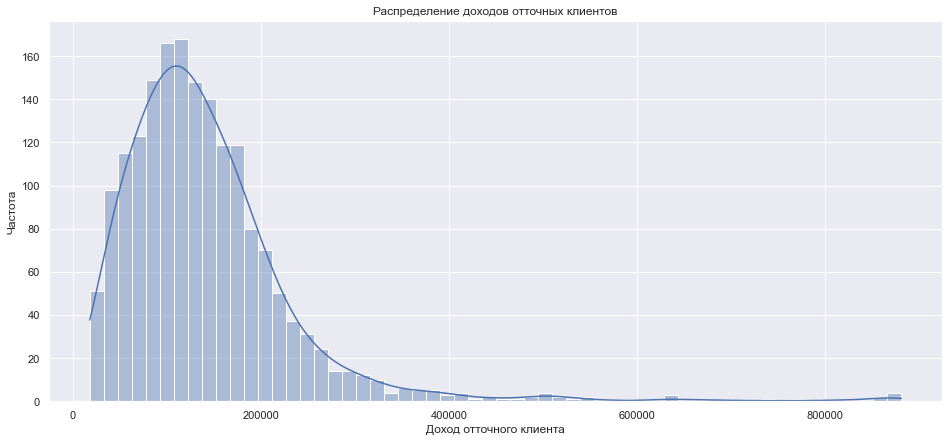

In [53]:
# Cтроим гистограмму
sns.histplot(data = est_sal_1, alpha=0.4, kde=True)
plt.title('Распределение доходов отточных клиентов' )
plt.xlabel('Доход отточного клиента')
plt.ylabel("Частота")
None

In [54]:
alpha = 0.05  # критический уровень статистической значимости

results = st.shapiro(est_sal_1)
p_value = results[1]

print('p-значение: ', p_value)

if p_value < alpha:
    print('Отвергаем нулевую гипотезу: распределение не нормально')
else:
    print('Не получилось отвергнуть нулевую гипотезу, всё нормально') 

p-значение:  1.2611686178923354e-44
Отвергаем нулевую гипотезу: распределение не нормально


In [55]:
# Выводим средние значения дохода лояльных (0) и отточных (1) клиентов
data.groupby('churn')['est_salary'].mean().to_frame().astype(int)

,est_salary
churn,
0,139389
1,142197


**Комментарий:** Обе выборки распределены не нормально, что подтверждено тестом Шапиро-Уилка, гисторгаммами распределения и статистическими характеристиками выборок. Обе имеют схожее распределение с характерной скошенностью вправо и присутствием "хвоста", свидетельствующем о выбивающихся значениях. Меры центранльной тенденции также говорят о ненормальности распределения (среднее арифметическое превышает медиану, стандартное отклонение отличается от среднего арифметического, значительный размах значений)

#### 4.1.2 Проверка гипотез с помощью критерия Стьюдента

**Формулировка гипотез:**

H0 - средний доход отточного клиента равен среднему доходу лояльного клиента \
Н1 - средний доход отточного клиента не равен среднему доходу лояльного клиента 

In [56]:
alpha = 0.05
results = st.ttest_ind(est_sal_1, 
                       est_sal_0,
                       equal_var=False)

print('P-value:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

P-value: 0.2738194291269684
Не получилось отвергнуть нулевую гипотезу


**Комментарий:** Для проверки гипотезы используем метод st.ttest_ind, который сравнивает средние двух выборок. Соответственно, нулевая гипотеза всегда предполагает равенство средних исследуемых выборок. Следовательно, альтернативная гипотеза звучит как среднее значение первой выборки не равно среднему значению второй выборки. Используем аргумент "two-sided" (идет по умолчанию), т к проверялась двусторонняя гипотеза: равны или не равны средние.

Полученное значение p-value (0.2738194291269684) заметно выше заданного уровня значимости, поэтому нулевая гипотеза не отвергается. Есть основания полагать, что средние доходы отточного и лояльного клиента равны.

Однако, учитывая, что распределение в обеих выборках не нормально, t-критерий вероятно был рассчитан некорректно. Необходимо проведение дополнительного теста для подтверждения или опровержения полученного результата

#### 4.1.3 Проверка гипотез с помощью критерия Манна-Уитни

**Формулировка гипотез:**

H0 - средний доход отточного клиента равен среднему доходу лояльного клиента \
Н1 - средний доход отточного клиента не равен среднему доходу лояльного клиента 

In [57]:
alpha = 0.05  # критический уровень статистической значимости

results = st.mannwhitneyu(est_sal_1, est_sal_0)

print('p-значение: ', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу: разница статистически значима')
else:
    print(
        'Не получилось отвергнуть нулевую гипотезу, вывод о различии сделать нельзя'
    )

p-значение:  0.00032780193557487827
Отвергаем нулевую гипотезу: разница статистически значима


U критерий Манна-Уитни применяется для выборок с ненормальным распределением/имеющимися выбросами. Поскольку это параметрический тест, использующий ранговые позиции вместо исходных данных, он позволяет нивелировать аномалии и получить более точные результаты нежели ttest.

Результат получился противоположным результату, полученному при помощи критерия Стьюдента, однако является более достоверным применительно и выборкам с ненормальным распределением. Соответственно, у нас есть основания полагать, что средние доходы отточного и лояльного клиента не равны.  

### 4.2 Проверка гипотезы о среднем возрасте отточного клиента

**Формулировка гипотез:**

H0 - средний возраст отточного клиента равен среднему возрасту лояльного клиента \
Н1 - средний возраст отточного клиента больше среднего возраста лояльного клиента

In [58]:
# Формируем выборки 

# Выборка доходов лояльных клиентов
age_0=data.loc[data['churn'] == 0]['age']
print('Размер выборки доходов лояльных клиентов: ', len(age_0), 'наблюдений')

# Выборка доходов отточных клиентов
age_1=data.loc[data['churn'] == 1]['age']
print('Размер выборки доходов отточных клиентов: ', len(age_1), 'наблюдений')

Размер выборки доходов лояльных клиентов:  7977 наблюдений
Размер выборки доходов отточных клиентов:  1796 наблюдений


In [59]:
# Проверяем выборку на нормальность распределения 
alpha = 0.05  

results = st.shapiro(age_0)
p_value = results[1]

print('p-значение: ', p_value)

if p_value < alpha:
    print('Отвергаем нулевую гипотезу: распределение не нормально')
else:
    print('Не получилось отвергнуть нулевую гипотезу, всё нормально') 

p-значение:  4.3019862854771884e-43
Отвергаем нулевую гипотезу: распределение не нормально


In [60]:
# Проверяем нормальность распределения значений
alpha = 0.05  

results = st.shapiro(age_1)
p_value = results[1]

print('p-значение: ', p_value)

if p_value < alpha:
    print('Отвергаем нулевую гипотезу: распределение не нормально')
else:
    print('Не получилось отвергнуть нулевую гипотезу, всё нормально') 

p-значение:  9.919191453651463e-24
Отвергаем нулевую гипотезу: распределение не нормально


In [61]:
# Проверяем гипотезу
alpha = 0.05  

results = st.mannwhitneyu(age_1, age_0, alternative='greater')

print('p-значение: ', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу: разница статистически значима')
else:
    print(
        'Не получилось отвергнуть нулевую гипотезу, вывод о различии сделать нельзя'
    )

p-значение:  0.9999981283760211
Не получилось отвергнуть нулевую гипотезу, вывод о различии сделать нельзя


**Комментарий:** учитывая ненормальное распределение данных, применен критерий критерий Манна-Уитни с правосторонним параметром 'greater'. p-value превышает уровень статистической значимости, следовательно, нулевая гипотеза не отвергается и есть основания полагать, что средний возраст отточного клиента равен среднему возрасту лояльного клиента

## Шаг 5 Промежуточный итог

В ходе исследования проведен анализ признаков отточности клиентов банка и по совокупности полученных характеристик установлены признаки, рекомендованные к применению при сегментации клиентов:


- *Баллы собственности* - собственность типичного отточного клиента оценивается в 4 балла (на 1 балл выше неотточного). Наибольшая доля оттока наблюдается в самых малочисленных группах клиентов (вероятно ВИП) с баллом собственности от 6 до 9. В этой прослойке клиентов доля оттока варьируется от 35 до 54%, что в несколько раз превышает среднюю по банку. Также весьма отточным представляется пласт клиентов с рейтингом собственности от 3 до 5, где отточность колеблется от 21 до 30%. Важно отметить, что именно эта группа составляет 50% от всей клиентской базы банка. Клиенты банка с низким уровнем собственности (0-2) являются самой лояльной аудиторией, особенно самая большая ее часть (2508 клиентов) с уровнем отточности 4%. Корреляционный анализ показал максимальную связь между баллами собственности и отточностью (0.35)
 

- *Количество банковских продуктов* - как правило лояльные и нелояльные клиенты пользуются 2 банковскими продуктами. Только клиенты с 1 пакетом продуктов не являются отточными (7% оттока), они составляются треть всех клиентов банка. Половина клиентов банка (5019) пользуется 2-мя пакетами продуктов и балансирует на грани отточности с 19%. На оставшуюся группу ~1500 клиентов приходятся наиболее выкоотточные клиенты: 3 пакета услуг - 29%, 5 пакетов - 42% и самая нелояльная категория -64% оттока среди клиентов с 4-мя пакетами. Анализ корреляции показал наличие умеренной взаимосвязи между количеством продуктов у клиента и отточностью (0.26)


- *Наличие недавней активности* - Из 5112 клиентов, совершавших в течение нескольких месяцев действия, потенциально связанные с их уходом из базы, 25% действительно приняли такое решение. Среди тех, кто такие действия не совершал, отточность лишь 11%. Типичный отточный клиент совершал такие действия, типичный лояльный - нет. Корреляционный анализ показал наличие значительной взаимосвязи между недавними активностями клиента и его скорым уходом (0.26)


- *Скоринговый балл* - у отточных и лояльных клиентов близок и составляет 862 и 845 баллов. При этом в зону риска попадают клиенты с кредитным скорингом в диапазоне от 825 до 911 и от 919 до 937 баллов, т е самые благонадежные клиенты. Была установлена умеренная взаимосвязь между количеством баллов и отточностью (0.23)


- *Пол* - клиентская база банка поровну распределена между мужчинами и женщинами (4899 и 4847 соответственно), но типичный отточный клиент – мужчина, лояльный – женщина. Действительно мужчины значительно чаще принимают решение прекратить обслуживание в банке: доля оттока клиентов мужского пола выше средней по банку и составляет 23.82%. Доля ушедших клиентов среди женщин в 2 раза ниже (12.9%). Коэффициент корреляции между полом и отточностью равен 0.22


Также в процессе сегментирования клиентов возможно включение следующих характеристик: 

- *Наличие кредитной карты* - типичные оттночные и неотточные клиенты пользуются кредитной картой. Отток среди клиентов, не пользующихся кредитными картами банка, превышает средний по банку на 8%, достигая 26%. 2/3 клиентов банка имеют кредитные карты, доля нелояльных клиентов среди них невысока - 15%. Между наличием кредитной карты и уровнем оттока обнаружена умеренная корреляция с коэффициентом 0.2

- *Возраст* - сравнение портретов типичного отточного и лояльного клиента показало очень близкие значения: 39 и 40 лет соответственно. При этом наиболее склонны к отказу от услуг банка клиенты в возрасте 25-34 и 49-59 лет. Коэффициент корреляции умеренно высокий (0.18)


Приведенные ниже характеристики могут иметь ограниченное применение в процессе сегментации высокоотточных клиентов, однако в ряде комбинаций с другими признаками также могут попадать в выделяемые сегменты:

- *Оцененный доход* - ежемесячный доход у типичного отточного и лояльного клиента практически совпадает и колеблется в районе 140’000 руб. Определенные зоны риска отточности по уровню дохода многочисленны и практически все превышают доход типичного отточного и неотточного клиента (99'000 - 135'000 , 143'000 - 215'000, 225'000 - 235'000, 254'000 - 265'000, 297'000 - 305'000, 325'000 - 335'000, 398'000 - 407'000, 498'000 - 515'000, 634'000 - 642'000, 850'000 - 859'000, 868'000 - 876'000), однако корреляция между оттоком и уровнем дохода незначительна (0.064)


- *Город* - отточность, превышающая среднебанковскую (18.38%), отмечена в Ярославле (19.18%) и Ростове (18.85%), при этом в Ярославле клиентская база в 4 раза больше, чем в Ростове: 5740 и 1384 соответственно. Вероятно поэтому как типичный отточный, так и типичный лояльный клиент зарегистрирован в Ярославле.  В Рыбинске ситуация немного лучше, однако доля отточных клиентов также значительна - 16.38% от общего количества 2649 клиентов. Корреляционный анализ не выявил значимой связи между этими характеристиками, более того коэффициент корреляции для этого признака наименьший из всех


- *Остаток средств на счете* -  в среднем остаток на счетах отточных клиентов на 30% превышает средства неотточных клиентов (1’085’909 против 713’129 руб). В зону риска отточности попадают обеспеченные клиенты с собственными средствами в диапазонах: 760'000-810'000, 900'000-1'050'000, 1'100'000 - 4'600'000, 6'000'000 - 7'000'000, 8'000'000 - 9'000'000, 11'000'000 - 13'000'000, 64'000'000 - 65'000'000. Вероятно такие клиенты могут быть отнесены к категории премиальных. При этом не удалось установить значимую связь между суммой остатка собственных средств и  отточностью (0,02)


## Шаг 6 Сегментация на основе стратегических показателей

In [62]:
# Выделяем первый сегмент
data.query('760000<=balance and last_activity==1 and gender_bin==1').agg({"churn":["mean","sum","count"]}).T

,mean,sum,count
churn,0.599419,413.0,689.0


In [63]:
# Выделяем второй сегмент 
data.query('credit_card==1 and 3<=products').agg({"churn":["mean","sum","count"]}).T

,mean,sum,count
churn,0.486919,335.0,688.0


In [64]:
# Выделяем третий сегмент 
data.query('500000<=balance and 25<=age<=34').agg({"churn":["mean","sum","count"]}).T

,mean,sum,count
churn,0.417488,339.0,812.0


**Комментарий:** В процессе сегментации были выделены следующие высокоотточные кластеры клиентов:

*Сегмент 1* -  Размер сегмента 689, уровень оттока 60%, отточных 413. Включает в себя мужчин с остатком на счете, превышающем 760'000 руб, совершавших в течение последних нескольких месяц действия, свидетельствующие о потенциальном желании уйти из банка


*Сегмент 2* -  Размер сегмента 688, уровень оттока 48%, отточных 335. Включает клиентов с более чем тремя продуктами банка, включая кредитную карту


*Сегмент 3* - Размер сегмента 812, уровень оттока 42%, отточных 339. Включает в себя молодых людей в возрасте от 25 до 34 лет с остатком на счете, превышающем 500'000 руб

## Шаг 7 Выводы и рекомендации для заказчика

В ходе исследования были выделены 3 высокоотчных сегмента клиентов, требующие дополнительного внимания и пересмотра существующих алгоритмов для удержания их в качестве клиентов банка. 

Ниже предложены рекомендации, направленные на оптимицамию работы с потенциально отточными клиентами в сформированных сегментах:

*Сегмент 1 - Мужчины с остатком на счете, превышающем 760'000 руб, совершавшие в течение последних нескольких месяцев действия, свидетельствующие о потенциальном желании уйти из банка*
Этот сегмент составляют наиболее состоятельные клиенты банка, как правило предприниматели, владельцы бизнесов, управленческий персонал высшего звена, видные представители сферы культуры, науки, политики. Это активные потребители услуг категории luxury, для них важен статус. Такие клиенты ожидают персонализированный подход к обслуживанию себя и своей семьи. Для повышения удержания поттенциально отточных клиентов в этом сегменте рекомендовано:
- Внедрение предоставления услуги личного менеджера (включая круглосуточную поддержку для ВИП  клиентов банка) и приоритетное обслуживание во всех отделениях банка в специальных выделенных зонах для премиальных клиентов без ожидания
- Предоставление персонализированных банковских продуктов и гибких условий (повышенный процент на остаток на счете, дополнительный кэшбэк, бесплатное обслуживание и страхование карт, дополнительный процент на накопительный счет)
- Доступ к разветвленной системе цифровых и дистанционных сервисов
- Предоставление качественного брокерского обслуживания, доступ к более широким возможностям инвестирования
- Операции с валютой на преференциальных условиях (сниженные комиссии при переводах, выгодные обменные курсы)
- Доступ в вип-залы аэропортов и бесплатное страхование жизни для членов семьи, система накопления миль
- Доступ к партнерским программам и услугам


*Сегмент 2 - Клиенты с тремя и более продуктами банка, включая кредитную карту*
Этот сегмент состоит из клиентов с очень большим количеством продуктов, включая один или несколько кредитных. Потенциальные причины ухода могут включать поиск более выгодных условий обслуживания, необходимость перекредитования, неудобство использования продуктов. Для повышения лояльности клиентов этого сегмента рекомендовано:
- Рассмотрение возможности предложения схем реструктуризации кредитных продуктов, предоставление налоговых каникул на небольшой срок или увеличение льготного периода по кредитной карте на 15-30 дней  
- Предоставление доступа к партнерским программам и программам кэшбэка
- Улучшение мобильного приложения и работы чата 
- Предоставление скидок на страховые продукты (карты, жизнь, имущество и т д )


*Сегмент 3 - Молодые люди в возрасте от 25 до 34 лет с остатком на счете, превышающем 500'000 руб*
В этот сегмент входят успешные молодые люди - предприниматели, IT специалисты, менеджеры среднего звена, члены влиятельных семей. Как правило это талантливые, хорошо образованные, предприимчивые люди, предпочитающие онлайн операции традиционному походу в отделение банка. Для таких клиентов важно предложить:
- удобную высокофункциональную инфраструктуру цифровых и дистанционных сервисов (мобильное приложение, чат бот, возможность совершать операции со счетами, включая валютный и брокерский)
- выгодные ипотечные продукты (для молодых семей, для IT специалистов)
- привлекательные условия по кэшбэку, накопительным и кредитным счетам
- доступ к расширенной партнерской программе 
- возможность снимать наличие в других странах бесплатно
